In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
from supervenn import supervenn
import os


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
import os
import pandas as pd

def get_dataframes_with_string(path: str, search_string: str) -> list:
    """
    Reads all CSV files in the specified directory that contain the given search string 
    in their filenames and returns a list of pandas DataFrames.
    
    Parameters:
    path (str): The directory path where the CSV files are located.
    search_string (str): The string to search for in the filenames.
    
    Returns:
    list: A list of pandas DataFrames, each corresponding to a CSV file whose name contains 
          the search string.
          
    Example:
    --------
    >>> dataframes = get_dataframes_with_string('/path/to/csv/files', 'example')
    >>> for df in dataframes:
    >>>     print(df)
    """
    dataframes = []
    
    # Iterate over all files in the given directory
    for filename in os.listdir(path):
        # Check if the file is a CSV file and contains the search string in its name
        if filename.endswith(".csv") and search_string in filename:
            # Create the full file path
            file_path = os.path.join(path, filename)
            # Read the CSV file into a dataframe
            df = pd.read_csv(file_path)
            # Append the dataframe to the list
            dataframes.append(df)
    
    return dataframes

In [3]:
def analyze_gene_data(dataframes: list) -> tuple:
    """
    Analyzes a list of dataframes to extract gene names that are upregulated 
    and downregulated in Alzheimer's Disease (AD) and the study names.
    
    Parameters:
    dataframes (list): A list of pandas DataFrames, each containing columns 
                       'gene_name' (str), 'is_upregulated_in_AD' (bool), and 'study' (str).
    
    Returns:
    tuple: A tuple containing four elements:
           1. A list of sets, each set containing gene names that are upregulated in AD for each dataframe.
           2. A list of sets, each set containing gene names that are downregulated in AD for each dataframe.
           3. A list of strings with the study name for each dataframe.
           4. A pandas DataFrame with a row for each gene name and a column for each study, 
              indicating if the gene is upregulated, downregulated, or missing in each study.
    
    Example:
    --------
    >>> dfs = [df1, df2, df3]
    >>> upregulated_genes, downregulated_genes, study_names, gene_summary_df = analyze_gene_data(dfs)
    >>> print(upregulated_genes)
    >>> print(downregulated_genes)
    >>> print(study_names)
    >>> print(gene_summary_df)
    """
    # Initialize lists to store the upregulated and downregulated genes for each dataframe
    upregulated_genes = []
    downregulated_genes = []
    study_names = []
    
    # Initialize a set to keep track of all unique gene names across all dataframes
    all_genes = set()

    # Iterate over each dataframe in the input list
    for df in dataframes:
        # Identify the set of upregulated genes in the current dataframe
        upregulated_set = set(df[df['is_upregulated_in_AD']]['gene_name'])
        # Identify the set of downregulated genes in the current dataframe
        downregulated_set = set(df[~df['is_upregulated_in_AD']]['gene_name'])
        # Extract the study name from the 'study' column of the current dataframe
        study_name = df['study'].iloc[0] if not df['study'].empty else None
        
        # Append the sets of upregulated and downregulated genes to their respective lists
        upregulated_genes.append(upregulated_set)
        downregulated_genes.append(downregulated_set)
        # Append the study name to the study names list
        study_names.append(study_name)
        # Update the set of all unique genes with the genes from the current dataframe
        all_genes.update(upregulated_set)
        all_genes.update(downregulated_set)
    
    # Create a DataFrame to summarize the gene regulation status across all studies
    gene_summary_df = pd.DataFrame(index=sorted(all_genes))

    # Iterate over each dataframe again to fill the summary DataFrame
    for idx, df in enumerate(dataframes):
        # Get the study name for the current dataframe
        study_name = study_names[idx]
        # Initialize the column for the current study with 'missing' status
        gene_summary_df[study_name] = "missing"
        # Get the sets of upregulated and downregulated genes for the current dataframe
        upregulated_set = upregulated_genes[idx]
        downregulated_set = downregulated_genes[idx]
        
        # Mark the upregulated genes in the current study as 'upregulated'
        gene_summary_df.loc[list(upregulated_set), study_name] = "upregulated"
        # Mark the downregulated genes in the current study as 'downregulated'
        gene_summary_df.loc[list(downregulated_set), study_name] = "downregulated"

    # Add columns for the number of upregulated and downregulated studies
    gene_summary_df['upregulated_count'] = (gene_summary_df == 'upregulated').sum(axis=1)
    gene_summary_df['downregulated_count'] = (gene_summary_df == 'downregulated').sum(axis=1)
    
    # Reset the index to turn the index into a column
    gene_summary_df.reset_index(inplace=True)
    # Rename the index column to 'gene_name'
    gene_summary_df.rename(columns={'index': 'gene_name'}, inplace=True)
    

    # Return the lists of upregulated and downregulated genes, study names, and the summary DataFrame
    return upregulated_genes, downregulated_genes, study_names, gene_summary_df

In [4]:
## Load data for each brain region
temporal_dataframes = get_dataframes_with_string('../../data/processed_data/overlap_analysis/overlap_analysis_input/', 'temporal')
frontal_dataframes = get_dataframes_with_string('../../data/processed_data/overlap_analysis/overlap_analysis_input/', 'frontal')
hippocampus_dataframes = get_dataframes_with_string('../../data/processed_data/overlap_analysis/overlap_analysis_input/', 'hippocampus')

In [5]:
## Get the sets for each brain region
temporal_up_genes, temporal_down_genes, temporal_study_names, temporal_summary = analyze_gene_data(temporal_dataframes)
frontal_up_genes, frontal_down_genes, frontal_study_names, frontal_summary = analyze_gene_data(frontal_dataframes)
hippocampus_up_genes, hippocampus_down_genes, hippocampus_study_names, hippocampus_summary = analyze_gene_data(hippocampus_dataframes)

In [6]:
## Save dataframes with summary information
temporal_summary.to_csv("../../data/processed_data/overlap_analysis/overlap_analysis_results/temporal_overlap_summary.tsv", index=False, sep="\t")
frontal_summary.to_csv("../../data/processed_data/overlap_analysis/overlap_analysis_results/frontal_overlap_summary.tsv", index=False, sep="\t")
hippocampus_summary.to_csv("../../data/processed_data/overlap_analysis/overlap_analysis_results/hippocampus_overlap_summary.tsv", index=False, sep="\t")

In [7]:
## Setup figure size
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (210*mm, 180*mm)
rcParams.update({'font.size': 5})
rcParams['axes.linewidth'] = 1

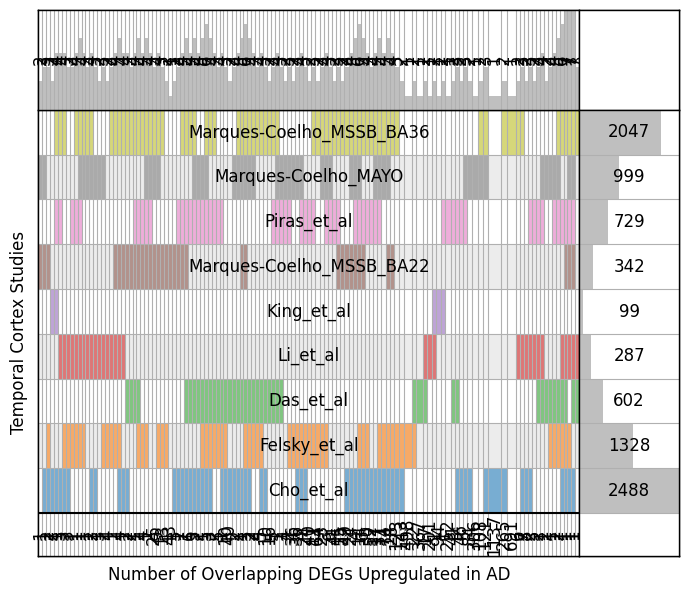

In [8]:
## Supervenn temporal lobe upregulated in AD genes
supervenn(temporal_up_genes, temporal_study_names, rotate_col_annotations=True, sets_ordering='minimize gaps',
         widths_minmax_ratio=0.3)

plt.ylabel("Temporal Cortex Studies")
plt.xlabel("Number of Overlapping DEGs Upregulated in AD")

plt.savefig('../../figures/01.overlap_analysis/temporal_upregulated_genes_supervenn.pdf', dpi=1200, transparent=True, bbox_inches="tight")

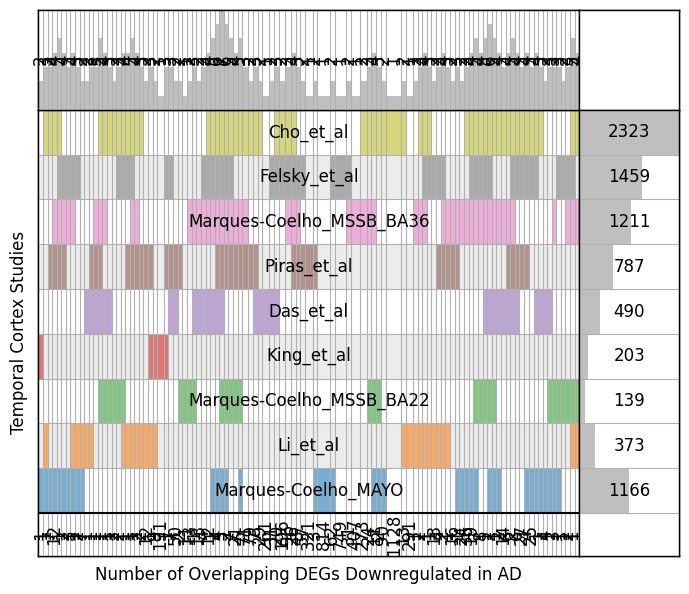

In [9]:
## Supervenn temporal lobe downregulated in AD genes
supervenn(temporal_down_genes, temporal_study_names, rotate_col_annotations=True, sets_ordering='minimize gaps',
         widths_minmax_ratio=0.3)

plt.ylabel("Temporal Cortex Studies")
plt.xlabel("Number of Overlapping DEGs Downregulated in AD")

plt.savefig('../../figures/01.overlap_analysis/temporal_downregulated_genes_supervenn.pdf', dpi=1200, transparent=True, bbox_inches="tight")

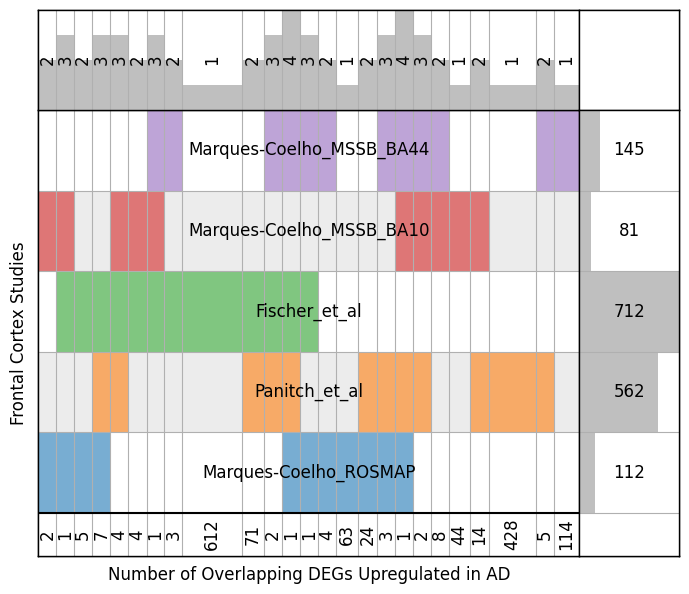

In [10]:
## Supervenn frontal lobe downregulated in AD genes
supervenn(frontal_up_genes, frontal_study_names, rotate_col_annotations=True, sets_ordering='minimize gaps',
         widths_minmax_ratio=0.3)

plt.ylabel("Frontal Cortex Studies")
plt.xlabel("Number of Overlapping DEGs Upregulated in AD")

plt.savefig('../../figures/01.overlap_analysis/frontal_upregulated_genes_supervenn.pdf', dpi=1200, transparent=True, bbox_inches="tight")

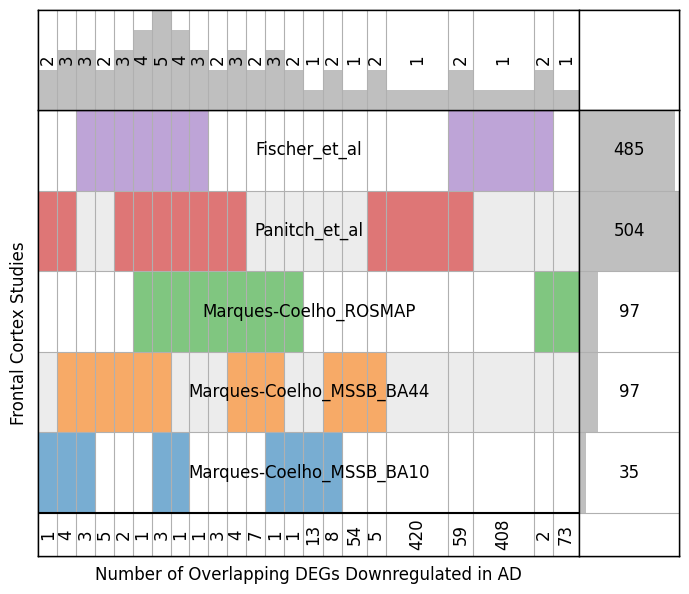

In [11]:
## Supervenn frontal lobe downregulated in AD genes
supervenn(frontal_down_genes, frontal_study_names, rotate_col_annotations=True, sets_ordering='minimize gaps',
         widths_minmax_ratio=0.3)

plt.ylabel("Frontal Cortex Studies")
plt.xlabel("Number of Overlapping DEGs Downregulated in AD")

plt.savefig('../../figures/01.overlap_analysis/frontal_downregulated_genes_supervenn.pdf', dpi=1200, transparent=True, bbox_inches="tight")

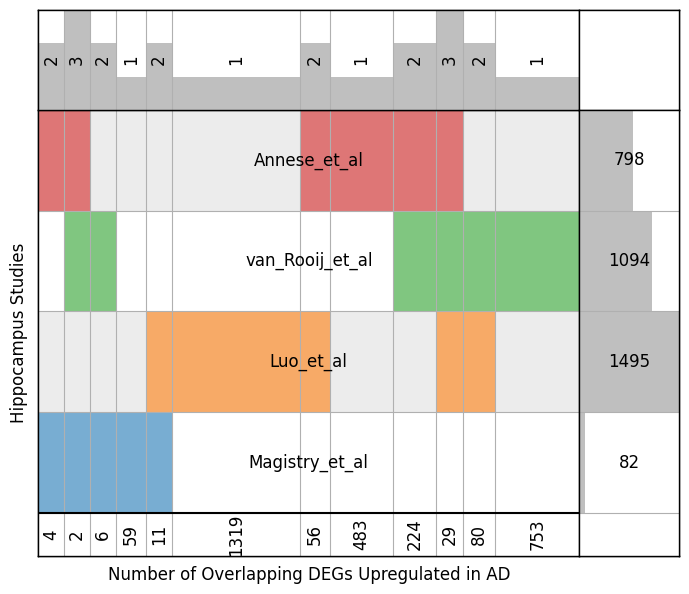

In [12]:
## Supervenn frontal lobe downregulated in AD genes
supervenn(hippocampus_up_genes, hippocampus_study_names, rotate_col_annotations=True, sets_ordering='minimize gaps',
         widths_minmax_ratio=0.2)

plt.ylabel("Hippocampus Studies")
plt.xlabel("Number of Overlapping DEGs Upregulated in AD")

plt.savefig('../../figures/01.overlap_analysis/hippocampus_upregulated_genes_supervenn.pdf', dpi=1200, transparent=True, bbox_inches="tight")

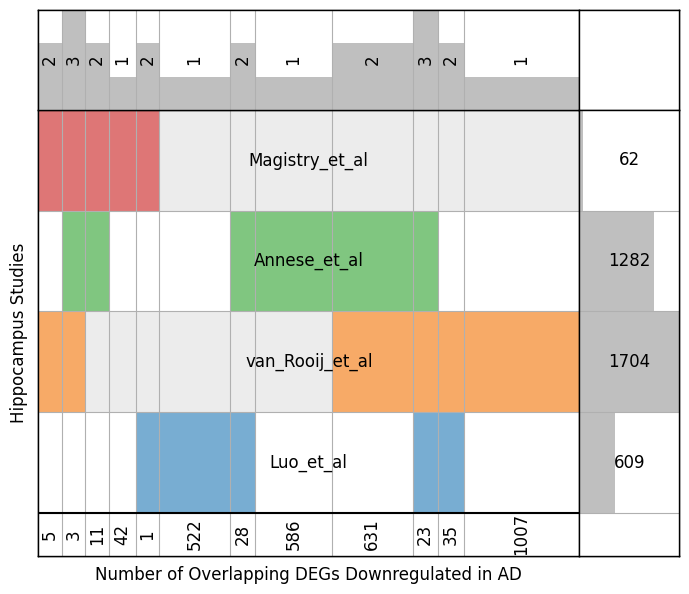

In [13]:
## Supervenn frontal lobe downregulated in AD genes
supervenn(hippocampus_down_genes, hippocampus_study_names, rotate_col_annotations=True, sets_ordering='minimize gaps',
         widths_minmax_ratio=0.2)

plt.ylabel("Hippocampus Studies")
plt.xlabel("Number of Overlapping DEGs Downregulated in AD")

plt.savefig('../../figures/01.overlap_analysis/hippocampus_downregulated_genes_supervenn.pdf', dpi=1200, transparent=True, bbox_inches="tight")